## Introduction to Object Detection

Object detection is a computer vision technique for locating instances of objects in images or videos. Object detection algorithms typically leverage machine learning or deep learning to produce meaningful results. When humans look at images or videos, we can recognize and locate objects of interest in a matter of moments. The goal of object detection is to replicate this intelligence using a computer.

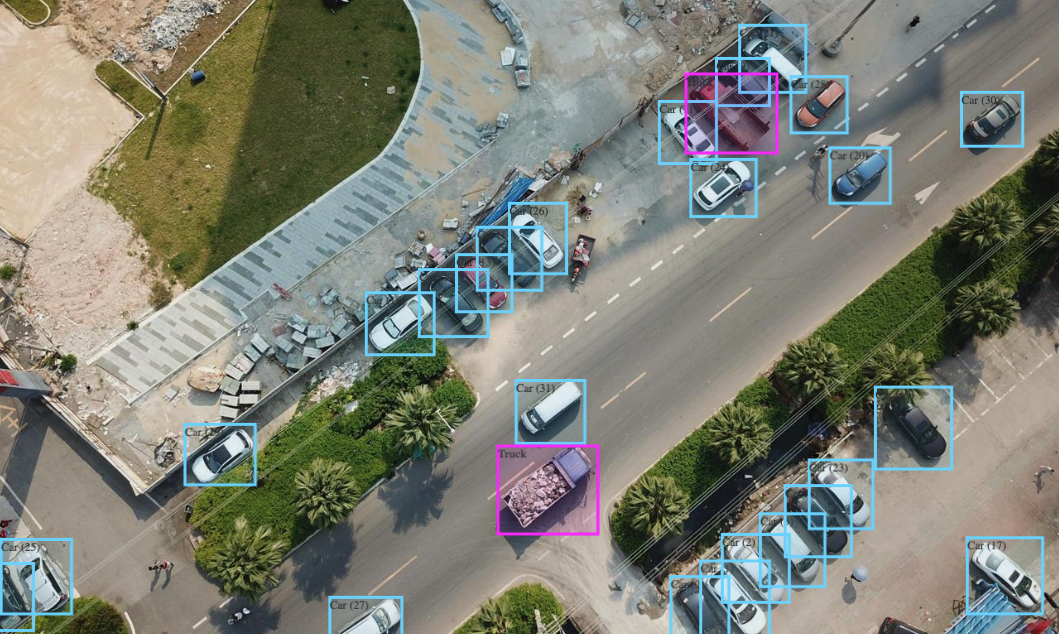

## Image Classification vs. Object Detection

Object detection is commonly confused with image recognition, so before we proceed, it's important to clarify the distinctions between them.

Image recognition assigns a label to an image. A photo of one dog is labeled "dog." A photo of two dogs is still labeled "dog." Object detection, on the other hand, draws a box around each dog and labels the box "dog." The model predicts where each object is and which label should be applied. In this way, object detection provides more information about an image than recognition.

Here's an example of what this distinction looks like in practice:

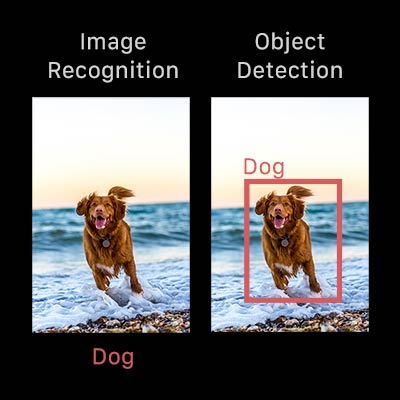

## YOLO Family

In 2015, a family of neural networks was proposed with the abbreviation YOLO, a reference to the notable phrase "You only live once." This is based on the simple fact that the network only "takes a look" or a pass through the network before producing the final image. This allows for the detection of objects with real-time images, which is considerably preferable for surveillance-related applications. The accuracy of the detected objects is lower than the previously mentioned models due to its exceptional speed, but it still manages to be a top competitor among the others.

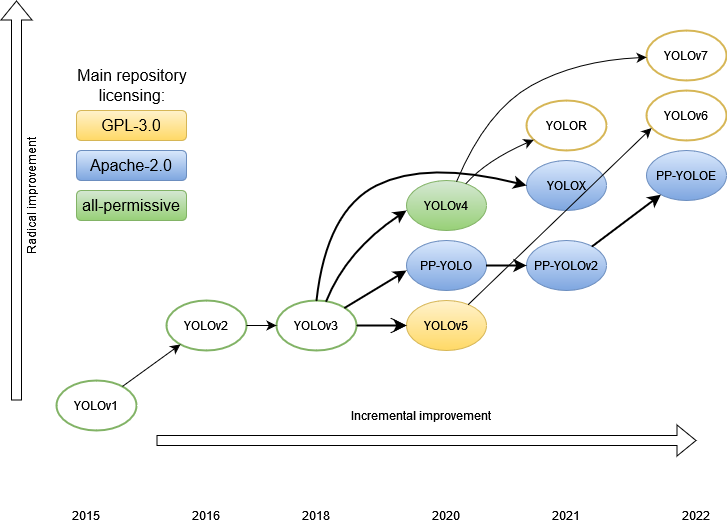

# Tree detection with YOLOv10

Link to access the Dataset: https://drive.google.com/drive/folders/17XEI_Ys6fR0bUZg3KK0wkyGaaiVDYM27?usp=sharing

In [ ]:
!pip install rasterio
!pip install albumentations==1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15


Here, we import the libraries and functions that we will need:

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from rasterio.features import rasterize
from rasterio.windows import Window
import os
from shapely.geometry import box
import pandas as pd
from skimage.io import imsave
from sklearn import model_selection
import os
import shutil
import json
import ast
import numpy as np
from tqdm import tqdm
import pandas as  pd
import seaborn as sns
import fastai.vision as vision
import glob
from skimage import io
from rasterio.plot import show

First we connect Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's import the image and view it:

In [ ]:
path_img = '/content/drive/MyDrive/Datasets/Dates_detection/IMG_train.tif'
path_points = '/content/drive/MyDrive/Datasets/Dates_detection/samples.shp'

In [ ]:
src = rasterio.open(path_img)

In [ ]:
img = src.read()

In [ ]:
img.shape

(6, 7856, 5370)

In [ ]:
img = img.transpose([1,2,0])

In [ ]:
img = img[:,:,0:3]

In [ ]:
img = img * 5 * 255
img = img.astype('uint8')

(-0.5, 5369.5, 7855.5, -0.5)

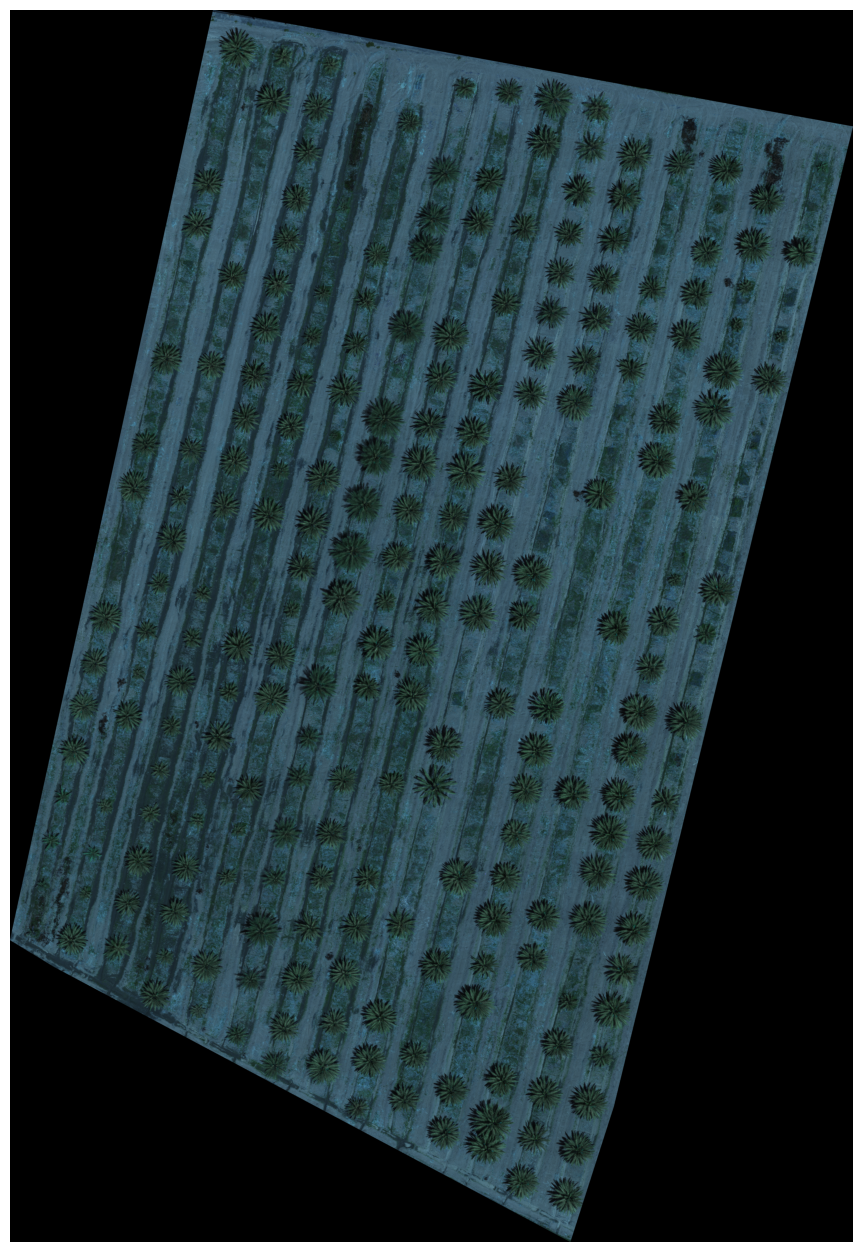

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(img)
plt.axis('off')

So, let's divide this image into several 1024x1024 pixel patches:

In [ ]:
os.mkdir('/content/data')

In [ ]:
qtd = 0
out_meta = src.meta.copy()
for n in range((src.meta['width']//1024)):
  for m in range((src.meta['height']//1024)):
    x = (n*1024)
    y = (m*1024)
    window = Window(x,y,1024,1024)
    win_transform = src.window_transform(window)
    arr_win = src.read(window=window)
    arr_win = arr_win[0:3,:,:]
    qtd = qtd + 1
    path_exp = '/content/data/img_' + str(qtd) + '.tif'
    out_meta.update({"driver": "GTiff","height": 1024,"width": 1024, "transform":win_transform})
    with rasterio.open(path_exp, 'w', **out_meta) as dst:
        for i, layer in enumerate(arr_win, start=1):
            dst.write_band(i, layer.reshape(-1, layer.shape[-1]))
    del arr_win

We then have the Data folder with the patches resulting from the split. Let's separate these images into training images and images for validation:

In [ ]:
path_data = '/content/data'

In [ ]:
images_files = [f for f in os.listdir(path_data)]

In [ ]:
images_files_train, images_files_valid= model_selection.train_test_split(
    images_files,
    test_size=0.1,
    random_state=42,
    shuffle=True,
)
print(len(images_files_train))
print(len(images_files_valid))

31
4


The patches are in .tiff format, but the YOLOv10 implementation requires images in .jpg format. Therefore, we will create two folders in our Google Colab content to store the training and validation images.

In [ ]:
destination_1 = 'train'
destination_2 = 'validation'

if not os.path.isdir(destination_1):
    os.mkdir(destination_1)
if not os.path.isdir(destination_2):
    os.mkdir(destination_2)

In [ ]:
path_data_new = '/content/train'
for images in images_files_train:
  src = rasterio.open(os.path.join(path_data,images))
  raster = src.read()
  raster = raster.transpose([1,2,0])
  raster = raster[:,:,0:3]
  raster = raster * 5 * 255
  raster = raster.astype(np.uint8)
  imsave(os.path.join(path_data_new,images.split('.')[0] + '.jpg'), raster)

<ipython-input-18-1c74dbe181a2>:9: UserWarning: /content/train/img_1.jpg is a low contrast image
  imsave(os.path.join(path_data_new,images.split('.')[0] + '.jpg'), raster)
<ipython-input-18-1c74dbe181a2>:9: UserWarning: /content/train/img_35.jpg is a low contrast image
  imsave(os.path.join(path_data_new,images.split('.')[0] + '.jpg'), raster)


In [ ]:
path_data_new = '/content/validation'
for images in images_files_valid:
  src = rasterio.open(os.path.join(path_data,images))
  raster = src.read()
  raster = raster.transpose([1,2,0])
  raster = raster[:,:,0:3]
  raster = raster * 5 * 255
  raster = raster.astype(np.uint8)
  imsave(os.path.join(path_data_new,images.split('.')[0] + '.jpg'), raster)

In [ ]:
gdf_tomate = gpd.read_file(path_points)

In [ ]:
Bound_list = []
for i,p in gdf_tomate.iterrows():
  bound = gdf_tomate['geometry'][i].bounds
  bound_rect = (bound[0],bound[1],bound[2],bound[3])
  geom = box(*bound_rect)
  Bound_list.append(geom)
gdf_bounds = gpd.GeoDataFrame(geometry=Bound_list)

However, we will only use the bounding boxes for each tree.

<Axes: >

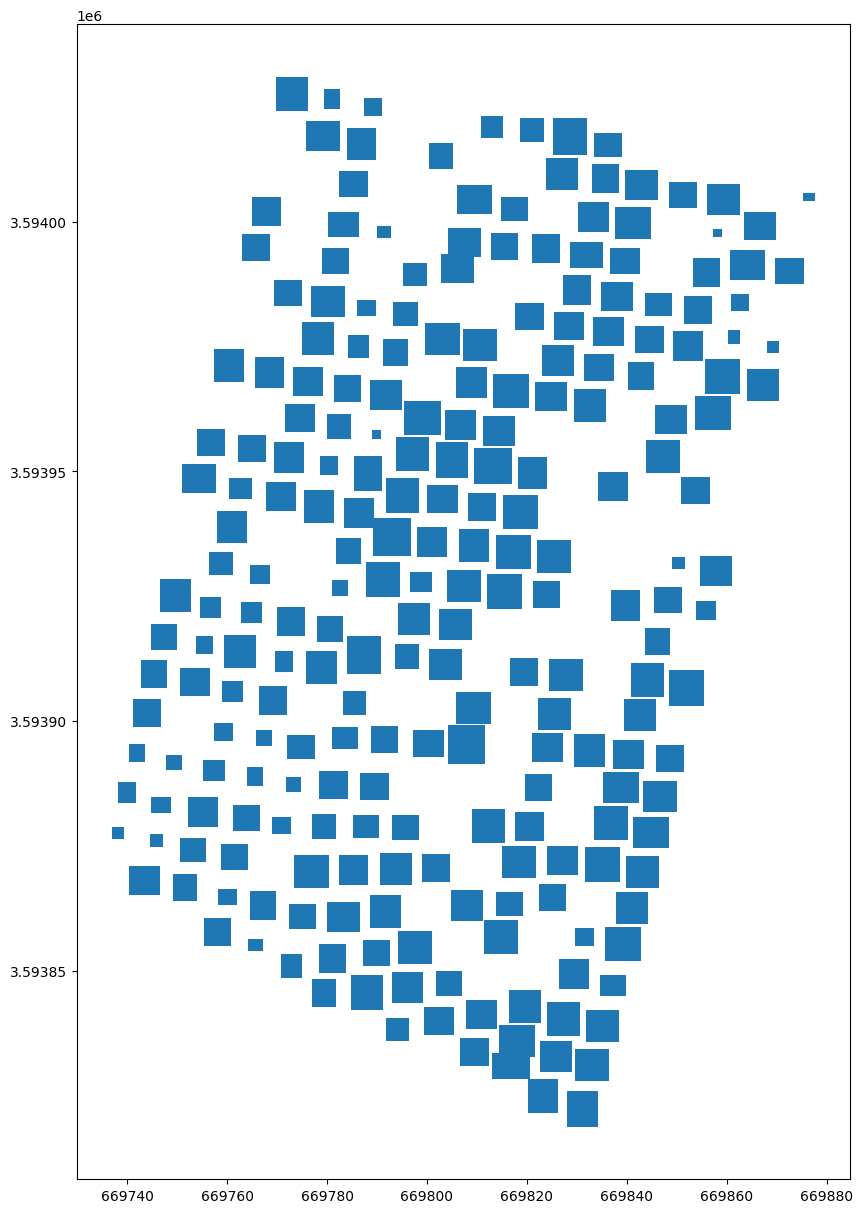

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_bounds.plot(ax = ax)

Now let's create the training and validation datasets with the bboxes that cross each of the patches:

In [ ]:
poly_geometry_train = []
img_id_train = []
for fp1 in images_files_train:
  src1 = rasterio.open(os.path.join(path_data,fp1))
  bounds1  = src1.bounds
  df1 = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds1)]})
  df1 = df1.set_crs(src1.crs)

  for i,row in gdf_bounds.iterrows():
    intersects = df1['geometry'][0].intersection(row['geometry'])
    if (intersects.is_empty == False):
      poly_geometry_train.append(intersects)
      img_id_train.append(fp1)

In [ ]:
poly_geometry_val = []
img_id_val = []
for fp2 in images_files_valid:
  src2 = rasterio.open(os.path.join(path_data,fp2))
  bounds2  = src2.bounds
  df2 = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds2)]})
  df2 = df2.set_crs(src2.crs)

  for i,row in gdf_bounds.iterrows():
    intersects = df2['geometry'][0].intersection(row['geometry'])
    if (intersects.is_empty == False):
      poly_geometry_val.append(intersects)
      img_id_val.append(fp2)

In [ ]:
dataset_train = gpd.GeoDataFrame(geometry=poly_geometry_train)
dataset_val = gpd.GeoDataFrame(geometry=poly_geometry_val)

In [ ]:
dataset_train['ImageId'] = img_id_train
dataset_val['ImageId'] = img_id_val

So we have the dataframe with the geometry of the bbox and the ID of the image to which it belongs:

In [ ]:
dataset_val

geometry     ImageId
0   POLYGON ((669789.484 3593849.205, 669791.248 3...  img_21.tif
1   POLYGON ((669789.484 3593856.255, 669792.564 3...  img_21.tif
2   POLYGON ((669789.484 3593861.887, 669794.82 35...  img_21.tif
3   POLYGON ((669794.261 3593851.317, 669794.261 3...  img_21.tif
4   POLYGON ((669792.906 3593843.481, 669792.906 3...  img_21.tif
..                                                ...         ...
58  POLYGON ((669789.484 3593884.125, 669786.525 3...  img_13.tif
59  POLYGON ((669789.484 3593876.558, 669785.256 3...  img_13.tif
60  POLYGON ((669782.366 3593867.252, 669782.366 3...  img_13.tif
61  POLYGON ((669780.063 3593861.887, 669780.063 3...  img_13.tif
62  POLYGON ((669789.484 3593861.887, 669788.617 3...  img_13.tif

[63 rows x 2 columns]

In [ ]:
df_train = []
Id_train = []
for i,row in dataset_train.iterrows():
  ImageID = row['ImageId'].split('.')[0] + '.jpg'
  src1 = rasterio.open(os.path.join(path_data,row['ImageId']))
  poly = []
  for point in list(row.geometry.exterior.coords):
    x = point[0]
    y = point[1]
    row, col = src1.index(x,y)
    tuple = (row,col)
    poly.append(tuple)
  Id_train.append(ImageID)
  df_train.append(poly)

In [ ]:
df_val = []
Id_val = []
for i,row in dataset_val.iterrows():
  ImageID = row['ImageId'].split('.')[0] + '.jpg'
  src2 = rasterio.open(os.path.join(path_data,row['ImageId']))
  poly = []
  for point in list(row.geometry.exterior.coords):
    x = point[0]
    y = point[1]
    row, col = src2.index(x,y)
    tuple = (row,col)
    poly.append(tuple)
  Id_val.append(ImageID)
  df_val.append(poly)

In [ ]:
train_set = pd.DataFrame([])
valid_set = pd.DataFrame([])

In [ ]:
train_set['ImageId'] = Id_train
valid_set['ImageId'] = Id_val

In [ ]:
train_set['geometry'] = df_train
valid_set['geometry'] = df_val

In [ ]:
train_set['class'] = 0
train_set['class_name'] = 'Dates'

valid_set['class'] = 0
valid_set['class_name'] = 'Dates'

In [ ]:
train_set

ImageId                                           geometry  class  \
0    img_16.jpg  [(271, 21), (184, 21), (184, 116), (271, 116),...      0   
1    img_16.jpg  [(719, 0), (719, 12), (836, 12), (836, 0), (71...      0   
2    img_16.jpg  [(0, 843), (100, 843), (100, 596), (0, 596), (...      0   
3    img_16.jpg  [(411, 530), (199, 530), (199, 768), (411, 768...      0   
4    img_16.jpg  [(596, 481), (387, 481), (387, 713), (596, 713...      0   
..          ...                                                ...    ...   
260   img_4.jpg  [(1024, 438), (1001, 438), (1001, 629), (1024,...      0   
261   img_3.jpg  [(286, 1024), (286, 893), (50, 893), (50, 1024...      0   
262   img_3.jpg  [(816, 771), (623, 771), (623, 969), (816, 969...      0   
263   img_3.jpg  [(1024, 665), (873, 665), (873, 906), (1024, 9...      0   
264   img_3.jpg  [(1024, 1024), (1024, 1002), (978, 1002), (978...      0   

    class_name  
0        Dates  
1        Dates  
2        Dates  
3        Dates  
4        Dates  
..         ...  
260      Dates  
261      Dates  
262      Dates  
263      Dates  
264      Dates  

[265 rows x 4 columns]

We only need to obtain the xmax, ymax, xmin, and ymin coordinates for each annotation. To do this, we will use the getBounds function:

In [ ]:
def getBounds(geometry):
    try:
        arr = np.array(geometry).T
        xmin = np.min(arr[0])
        ymin = np.min(arr[1])
        xmax = np.max(arr[0])
        ymax = np.max(arr[1])
        return (xmin, ymin, xmax, ymax)
    except:
        return np.nan

def getWidth(bounds):
    try:
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(xmax - xmin)
    except:
        return np.nan

def getHeight(bounds):
    try:
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(ymax - ymin)
    except:
        return np.nan

In [ ]:
train_set.loc[:,'bounds'] = train_set.loc[:,'geometry'].apply(getBounds)
train_set.loc[:,'width'] = train_set.loc[:,'bounds'].apply(getWidth)
train_set.loc[:,'height'] = train_set.loc[:,'bounds'].apply(getHeight)
train_set.head(10)

ImageId                                           geometry  class  \
0  img_16.jpg  [(271, 21), (184, 21), (184, 116), (271, 116),...      0   
1  img_16.jpg  [(719, 0), (719, 12), (836, 12), (836, 0), (71...      0   
2  img_16.jpg  [(0, 843), (100, 843), (100, 596), (0, 596), (...      0   
3  img_16.jpg  [(411, 530), (199, 530), (199, 768), (411, 768...      0   
4  img_16.jpg  [(596, 481), (387, 481), (387, 713), (596, 713...      0   
5  img_16.jpg  [(617, 204), (452, 204), (452, 379), (617, 379...      0   
6  img_16.jpg  [(907, 131), (734, 131), (734, 310), (907, 310...      0   
7  img_16.jpg  [(1024, 360), (889, 360), (889, 614), (1024, 6...      0   
8  img_16.jpg  [(1024, 60), (1003, 60), (1003, 242), (1024, 2...      0   
9  img_16.jpg  [(0, 1024), (154, 1024), (154, 907), (0, 907),...      0   

  class_name                 bounds  width  height  
0      Dates    (184, 21, 271, 116)     87      95  
1      Dates      (719, 0, 836, 12)    117      12  
2      Dates     (0, 596, 100, 843)    100     247  
3      Dates   (199, 530, 411, 768)    212     238  
4      Dates   (387, 481, 596, 713)    209     232  
5      Dates   (452, 204, 617, 379)    165     175  
6      Dates   (734, 131, 907, 310)    173     179  
7      Dates  (889, 360, 1024, 614)    135     254  
8      Dates  (1003, 60, 1024, 242)     21     182  
9      Dates    (0, 907, 154, 1024)    154     117

In [ ]:
valid_set.loc[:,'bounds'] = valid_set.loc[:,'geometry'].apply(getBounds)
valid_set.loc[:,'width'] = valid_set.loc[:,'bounds'].apply(getWidth)
valid_set.loc[:,'height'] = valid_set.loc[:,'bounds'].apply(getHeight)
valid_set.head(10)

ImageId                                           geometry  class  \
0  img_21.jpg  [(455, 0), (455, 63), (705, 63), (705, 0), (45...      0   
1  img_21.jpg  [(202, 0), (202, 110), (389, 110), (389, 0), (...      0   
2  img_21.jpg   [(0, 0), (0, 191), (116, 191), (116, 0), (0, 0)]      0   
3  img_21.jpg  [(379, 171), (140, 171), (140, 414), (379, 414...      0   
4  img_21.jpg  [(661, 122), (438, 122), (438, 348), (661, 348...      0   
5  img_21.jpg  [(933, 83), (769, 83), (769, 246), (933, 246),...      0   
6  img_21.jpg  [(0, 781), (68, 781), (68, 551), (0, 551), (0,...      0   
7  img_21.jpg  [(610, 442), (425, 442), (425, 626), (610, 626...      0   
8  img_21.jpg  [(885, 357), (689, 357), (689, 569), (885, 569...      0   
9  img_21.jpg  [(1024, 1024), (1024, 847), (1018, 847), (1018...      0   

  class_name                   bounds  width  height  
0      Dates        (455, 0, 705, 63)    250      63  
1      Dates       (202, 0, 389, 110)    187     110  
2      Dates         (0, 0, 116, 191)    116     191  
3      Dates     (140, 171, 379, 414)    239     243  
4      Dates     (438, 122, 661, 348)    223     226  
5      Dates      (769, 83, 933, 246)    164     163  
6      Dates        (0, 551, 68, 781)     68     230  
7      Dates     (425, 442, 610, 626)    185     184  
8      Dates     (689, 357, 885, 569)    196     212  
9      Dates  (1018, 847, 1024, 1024)      6     177

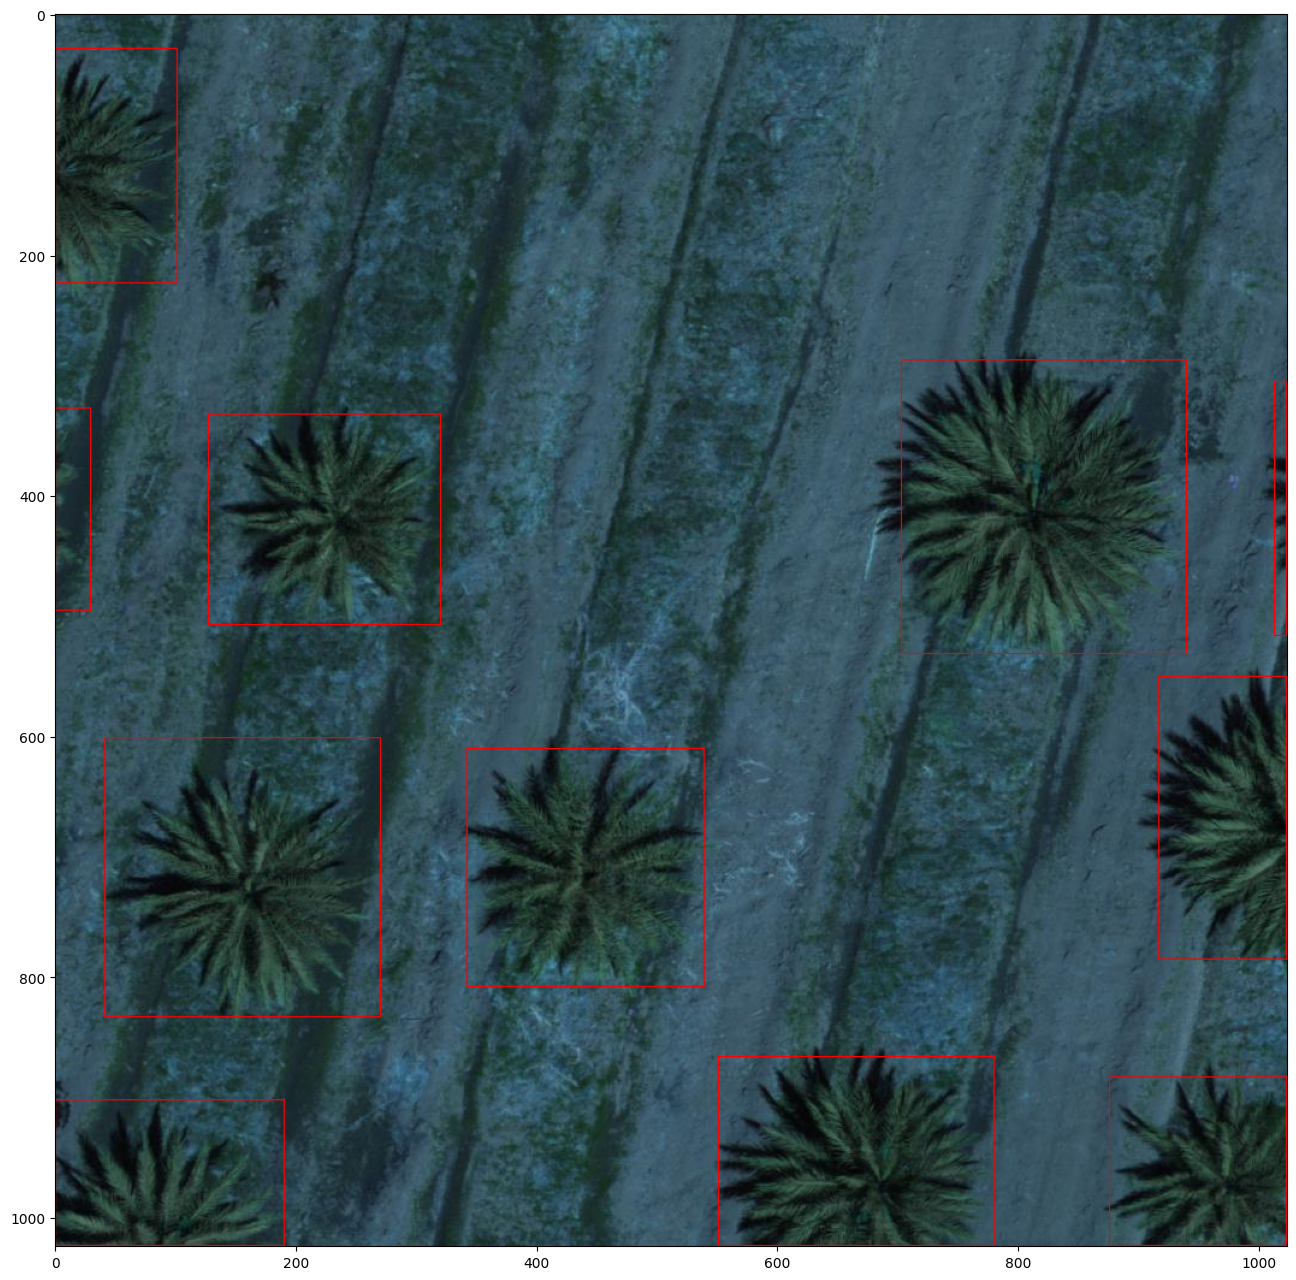

In [ ]:
img = io.imread('/content/train/img_20.jpg')

detec = train_set[train_set['ImageId'] == 'img_20.jpg']
for i, row in detec.iterrows():
  color = (255,0,0)
  cv2.rectangle(img, (max(0, row['bounds'][1]), max(0, row['bounds'][0]) , max(0, row['bounds'][3] - row['bounds'][1]), max(0, row['bounds'][2] - row['bounds'][0])), color, 1)
plt.figure(figsize=(16,16))
plt.imshow(img)

After that, we created the .csv files to use in YOLOv10:

In [ ]:
def convert(data, data_type):
    df = data.groupby('ImageId')['bounds'].apply(list).reset_index(name='bboxes')
    df['classes'] = data.groupby('ImageId')['class'].apply(list).reset_index(drop=True)
    df.to_csv(data_type + '.csv', index=False)
    print(data_type)
    print(df.shape)
    print(df.head())

df_train = convert(train_set, '/content/train')
df_valid = convert(valid_set, '/content/validation')

/content/train
(28, 3)
      ImageId                                             bboxes  \
0  img_11.jpg  [(0, 0, 102, 144), (0, 245, 187, 462), (192, 0...   
1  img_14.jpg  [(0, 129, 61, 317), (195, 116, 287, 224), (0, ...   
2  img_15.jpg  [(294, 0, 422, 56), (509, 0, 738, 7), (617, 39...   
3  img_16.jpg  [(184, 21, 271, 116), (719, 0, 836, 12), (0, 5...   
4  img_17.jpg  [(0, 360, 90, 614), (0, 60, 170, 242), (272, 0...   

                                         classes  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2                             [0, 0, 0, 0, 0, 0]  
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
/content/validation
(4, 3)
      ImageId                                             bboxes  \
0  img_10.jpg  [(0, 500, 94, 733), (0, 830, 116, 985), (50, 0...   
1  img_12.jpg  [(688, 0, 818, 7), (390, 0, 539, 78), (59, 0, ...   
2  img_13.jpg  [(0, 108, 120, 2

In [ ]:
!mkdir plant_data
%cd plant_data

/content/plant_data


In [ ]:
!mkdir images
!mkdir labels
%cd images
!mkdir train
!mkdir validation
%cd ..
%cd labels
!mkdir train
!mkdir validation
%cd ..
%cd ..


/content/plant_data/images
/content/plant_data
/content/plant_data/labels
/content/plant_data
/content


In [ ]:
INPUT_PATH = '/content/'
OUTPUT_PATH = '/content/plant_data'
def process_data(data, data_type='train'):
    for _, row in tqdm(data.iterrows(), total = len(data)):
        image_name = row['ImageId'].split('.')[0]
        bounding_boxes = row['bboxes']
        classes = row['classes']
        yolo_data = []

        for bbox, Class in zip(bounding_boxes, classes):

            x_min = bbox[1]
            y_min = bbox[0]
            x_max = bbox[3]
            y_max = bbox[2]

            x_center = (x_min + x_max) / 2.0 / 1024
            y_center = (y_min + y_max) / 2.0 / 1024
            x_extend = (x_max - x_min) / 1024
            y_extend = (y_max - y_min) / 1024

            yolo_data.append([Class, x_center, y_center, x_extend, y_extend])

        yoy_data = np.array(yolo_data)
        np.savetxt(
            os.path.join(OUTPUT_PATH, f"labels/{data_type}/{image_name}.txt"),
            yolo_data,
            fmt = ["%d", "%f", "%f", "%f", "%f"]
        )
        shutil.copyfile(
            os.path.join(INPUT_PATH, f"{data_type}/{image_name}.jpg"),
            os.path.join(OUTPUT_PATH, f"images/{data_type}/{image_name}.jpg")
        )

df_train = pd.read_csv('/content/train.csv')
df_train.bboxes = df_train.bboxes.apply(ast.literal_eval)
df_train.classes = df_train.classes.apply(ast.literal_eval)

df_valid = pd.read_csv('/content/validation.csv')
df_valid.bboxes = df_valid.bboxes.apply(ast.literal_eval)
df_valid.classes = df_valid.classes.apply(ast.literal_eval)

process_data(df_train, data_type='train')
process_data(df_valid, data_type='validation')

100%|██████████| 4/4 [00:00<00:00, 1111.29it/s]


In [ ]:
f = open('/content/plant_data/labels/train/'+os.listdir("/content/plant_data/labels/train/")[1])
print(f.name)
for l in f:
    print(l)

/content/plant_data/labels/train/img_27.txt
0 0.022949 0.931152 0.045898 0.137695

0 0.065430 0.652344 0.130859 0.230469

0 0.094238 0.401367 0.188477 0.207031

0 0.151855 0.126953 0.186523 0.189453

0 0.248047 0.901855 0.189453 0.190430

0 0.317871 0.641113 0.217773 0.208008

0 0.730957 0.127441 0.252930 0.215820

0 0.660156 0.377441 0.234375 0.241211

0 0.600098 0.667480 0.243164 0.245117

0 0.807129 0.932129 0.225586 0.135742

0 0.882812 0.725098 0.228516 0.223633

0 0.909668 0.442383 0.180664 0.216797

0 0.943848 0.189941 0.112305 0.217773

0 0.989746 0.010254 0.020508 0.020508



After preparing the data, we will create the YAML configuration file and clone the YOLOv10 implementation's GitHub repository, downloading the necessary files for its use:

In [ ]:
%%writefile dates_tree.yaml

train: /content/plant_data/images/train
val: /content/plant_data/images/validation
nc: 1
names: ['Dates Tree']

Writing dates_tree.yaml


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q supervision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


We can begin the training:

In [ ]:
%cd {HOME}

!yolo task=detect mode=train epochs=60 batch=16 plots=True \
model={HOME}/weights/yolov10x.pt \
data={HOME}/dates_tree.yaml

/content
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New h

Upon completion of the training, a folder was generated containing the results of the metrics and the trained weights:

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png		train_batch101.jpg
confusion_matrix_normalized.png			    PR_curve.png	train_batch102.jpg
confusion_matrix.png				    R_curve.png		train_batch1.jpg
events.out.tfevents.1727277222.fd3882783696.2196.0  results.csv		train_batch2.jpg
F1_curve.png					    results.png		val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	val_batch0_pred.jpg
labels.jpg					    train_batch100.jpg	weights


In [ ]:
from IPython.display import Image

/content


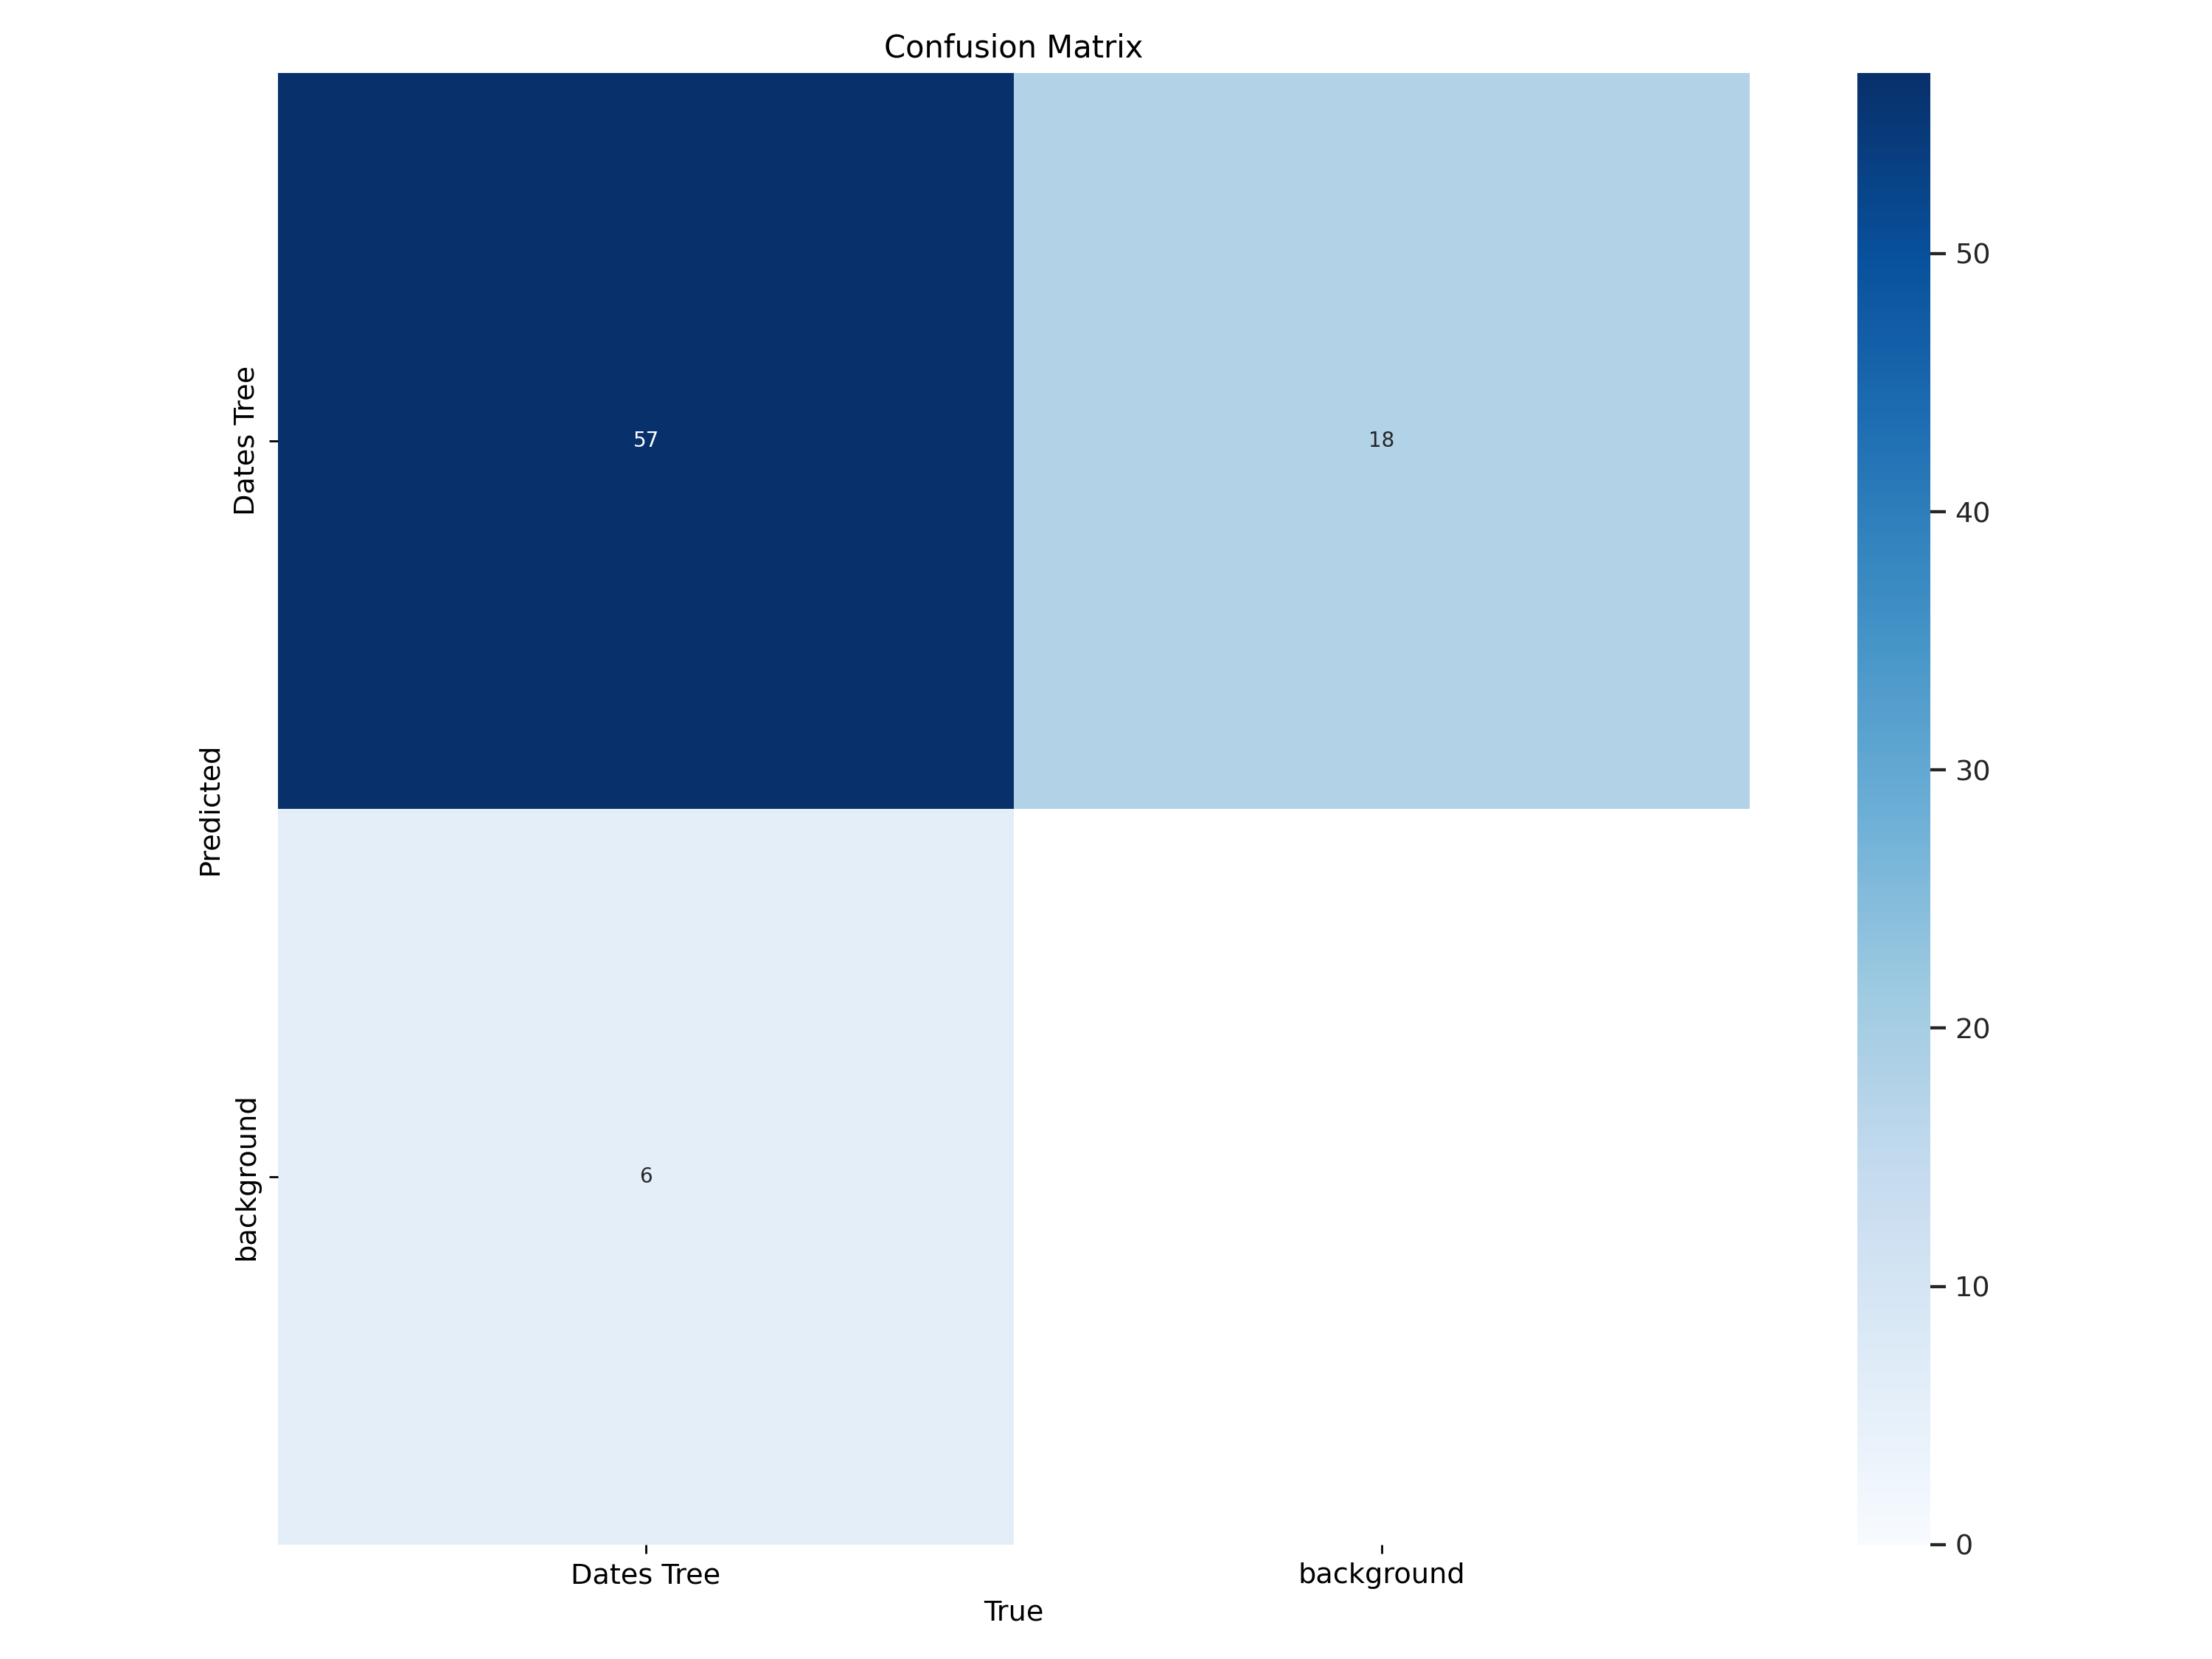

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


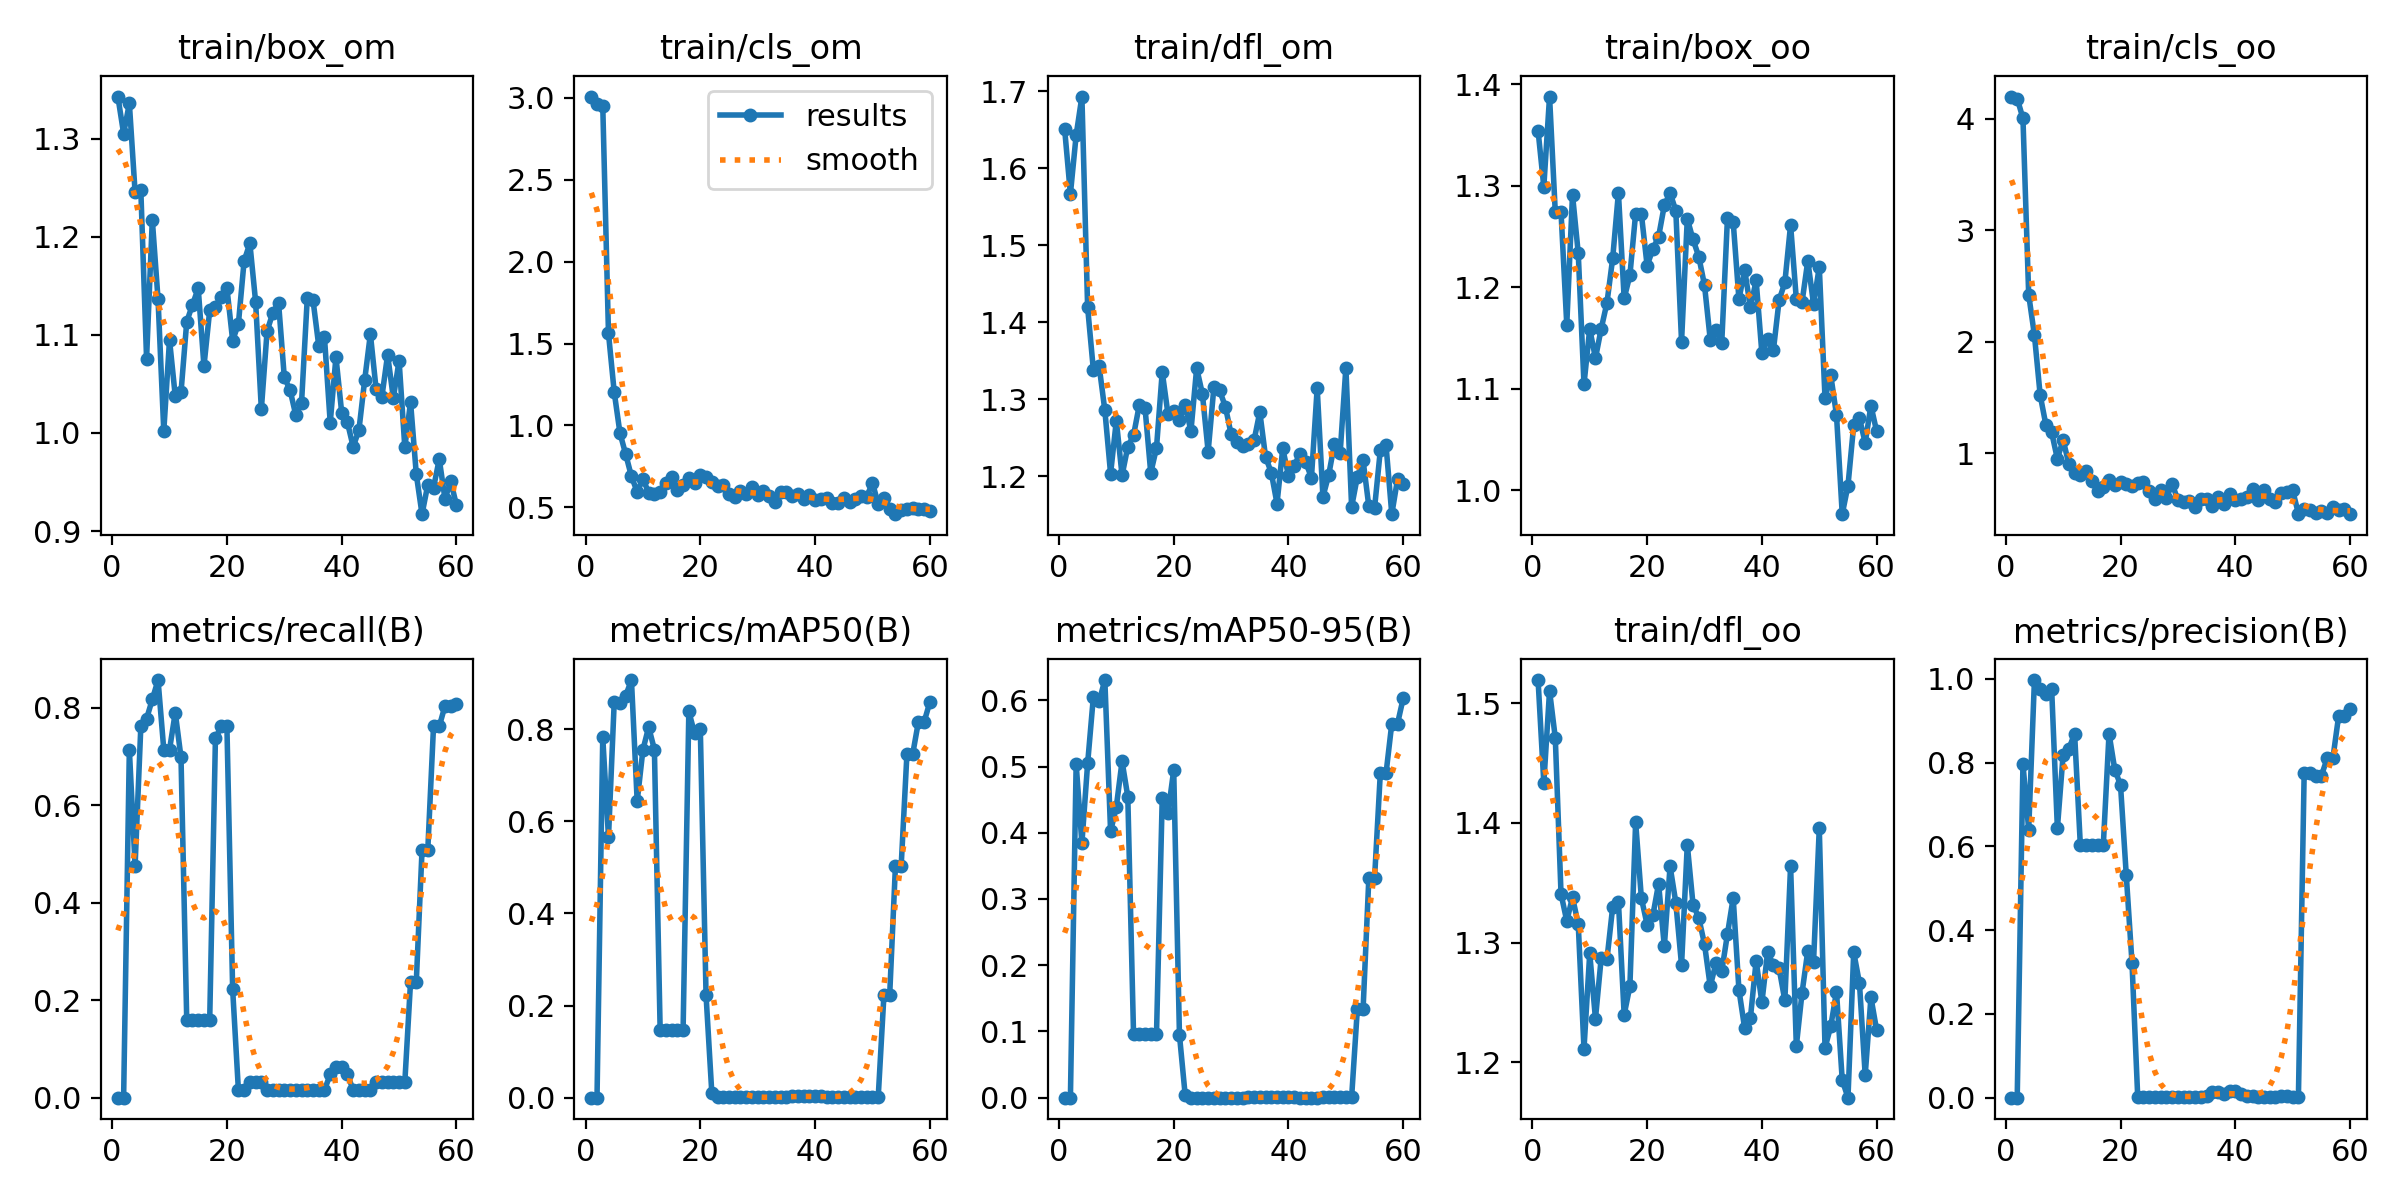

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
!pip install ultralytics

We can apply our trained model to the validation images:

In [ ]:
from ultralytics import YOLOv10
model = YOLOv10("runs/detect/train/weights/best.pt")
model.predict('/content/validation', save=True, save_txt=True)

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")



image 1/4 /content/validation/img_10.jpg: 640x640 16 Dates Trees, 20.8ms
image 2/4 /content/validation/img_12.jpg: 640x640 19 Dates Trees, 18.6ms
image 3/4 /content/validation/img_13.jpg: 640x640 22 Dates Trees, 18.5ms
image 4/4 /content/validation/img_21.jpg: 640x640 18 Dates Trees, 18.7ms
Speed: 4.0ms preprocess, 19.2ms inference, 23.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
4 labels saved to runs/detect/predict/labels


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Dates Tree'}
 obb: None
 orig_img: array([[[ 59,  60,  34],
         [ 58,  59,  33],
         [ 57,  58,  32],
         ...,
         [ 89,  75,  46],
         [ 88,  74,  45],
         [ 90,  76,  47]],
 
        [[ 62,  61,  35],
         [ 59,  60,  34],
         [ 59,  58,  32],
         ...,
         [ 95,  81,  52],
         [ 94,  80,  51],
         [ 96,  82,  53]],
 
        [[ 68,  64,  39],
         [ 65,  64,  38],
         [ 65,  61,  36],
         ...,
         [102,  88,  59],
         [101,  87,  58],
         [101,  87,  58]],
 
        ...,
 
        [[ 56,  51,  30],
         [ 57,  52,  31],
         [ 58,  51,  32],
         ...,
         [ 74,  84,  54],
         [ 73,  81,  51],
         [ 60,  68,  38]],
 
        [[ 56,  51,  30],
         [ 57,  52,  31],
         [ 58,  51,  32],
         ...,
         [ 73,

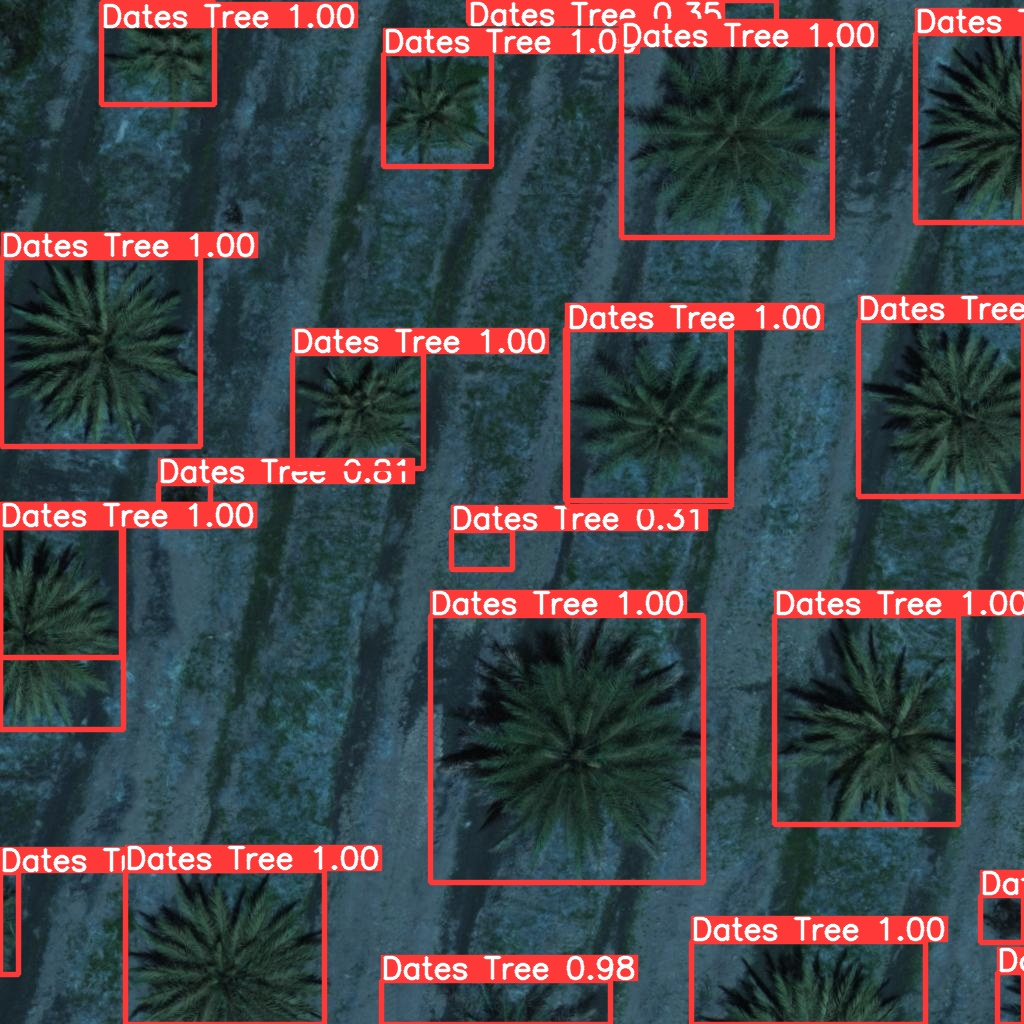

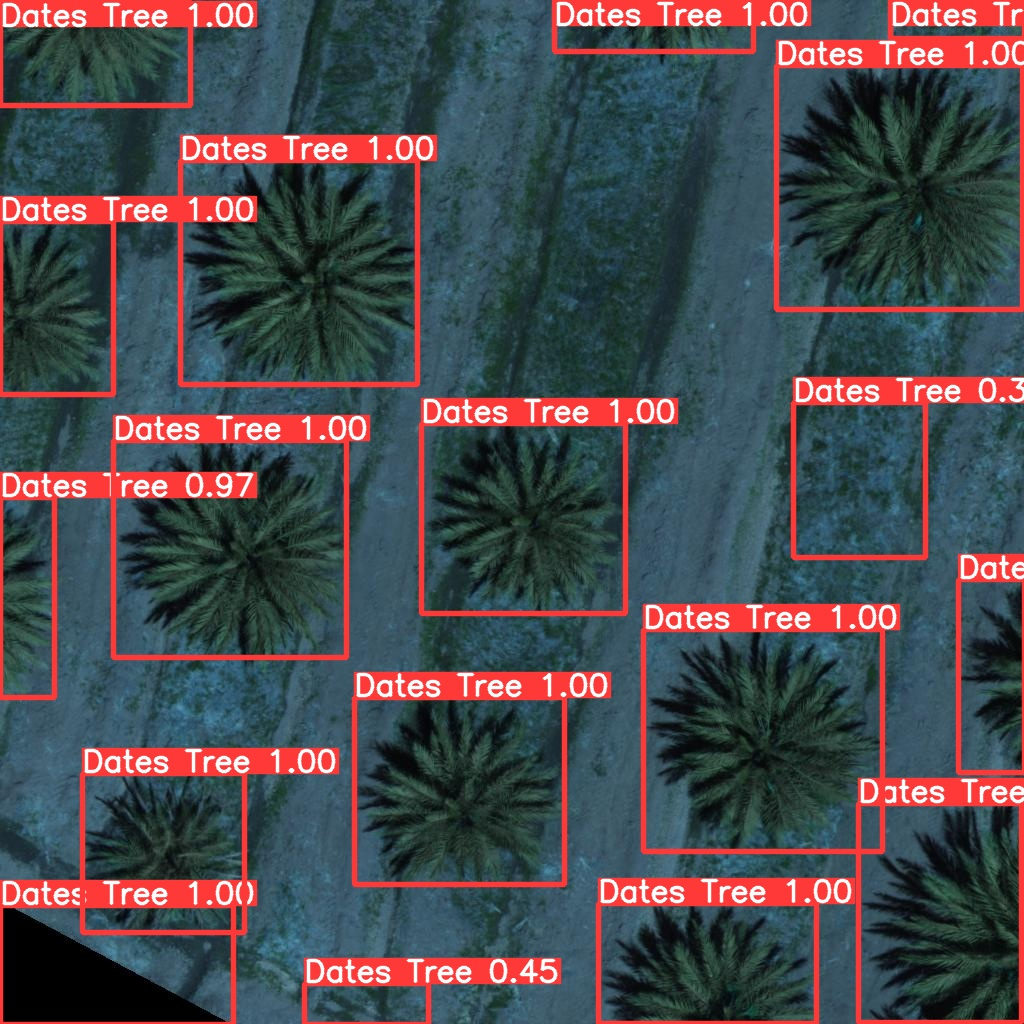

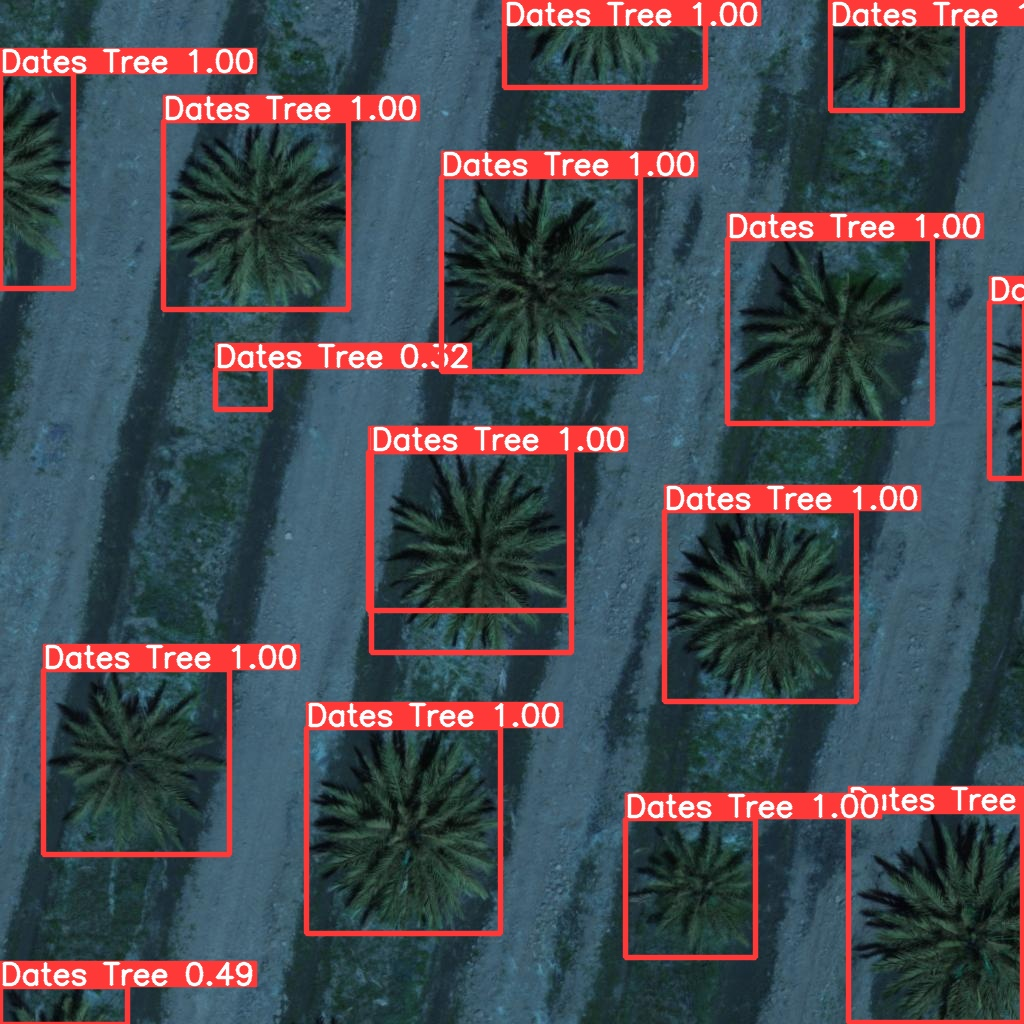

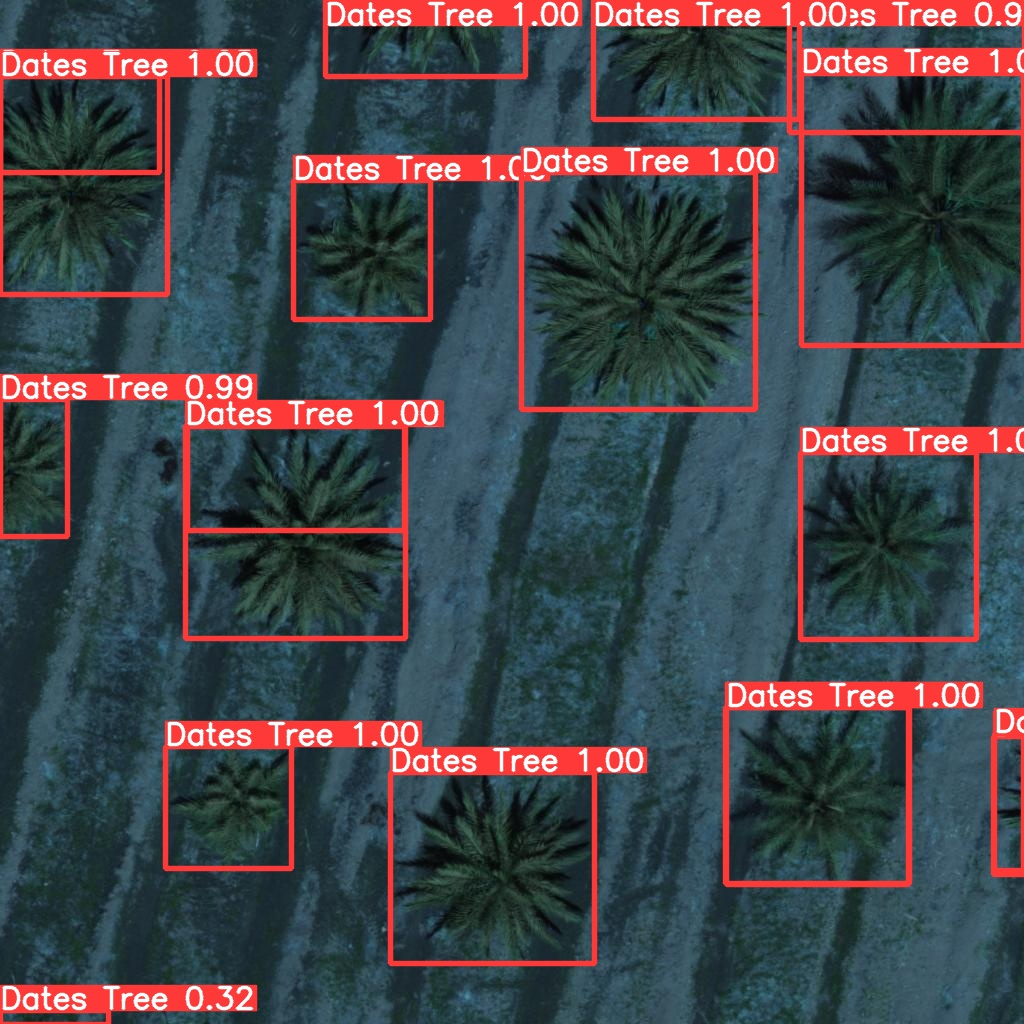

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg'):
      display(Image(filename=image_path, width=600))
      print("\n")